In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

possible_paths = ["CreditScoring.csv", "/mnt/data/CreditScoring.csv"]
csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("CreditScoring.csv not found. Put the file in the notebook folder or /mnt/data/")

print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())



Using CSV: CreditScoring.csv
Shape: (4455, 14)
Columns: ['Status', 'Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records', 'Job', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price']


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:

print("Status value counts:\n", df['Status'].value_counts())

df['default'] = (df['Status'] == 2).astype(int)
print("\nDefault distribution (1=default):")
print(df['default'].value_counts())


Status value counts:
 Status
1    3200
2    1254
0       1
Name: count, dtype: int64

Default distribution (1=default):
default
0    3201
1    1254
Name: count, dtype: int64


In [5]:

eps = 1e-6
df['debt_to_income'] = df['Debt'] / (df['Income'] + eps)
df['expenses_to_income'] = df['Expenses'] / (df['Income'] + eps)
df['assets_to_debt'] = df['Assets'] / (df['Debt'] + eps)

# Show the new columns
display(df[['Debt','Income','Expenses','Assets','debt_to_income','expenses_to_income','assets_to_debt']].head())


,Debt,Income,Expenses,Assets,debt_to_income,expenses_to_income,assets_to_debt
0,0,129,73,0,0.0,0.565891,0.000000e+00
1,0,131,48,0,0.0,0.366412,0.000000e+00
2,0,200,90,3000,0.0,0.450000,3.000000e+09
3,0,182,63,2500,0.0,0.346154,2.500000e+09
4,0,107,46,0,0.0,0.429907,0.000000e+00


In [6]:

candidate_features = [
    'Seniority','Time','Age','Expenses','Income','Assets','Debt','Amount','Price',
    'debt_to_income','expenses_to_income','assets_to_debt','Home','Marital','Records','Job'
]


features = [c for c in candidate_features if c in df.columns]
X = df[features].copy()
y = df['default'].copy()

print("Using feature columns:", features)
display(X.head())


Using feature columns: ['Seniority', 'Time', 'Age', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price', 'debt_to_income', 'expenses_to_income', 'assets_to_debt', 'Home', 'Marital', 'Records', 'Job']


,Seniority,Time,Age,Expenses,Income,Assets,Debt,Amount,Price,debt_to_income,expenses_to_income,assets_to_debt,Home,Marital,Records,Job
0,9,60,30,73,129,0,0,800,846,0.0,0.565891,0.000000e+00,1,2,1,3
1,17,60,58,48,131,0,0,1000,1658,0.0,0.366412,0.000000e+00,1,3,1,1
2,10,36,46,90,200,3000,0,2000,2985,0.0,0.450000,3.000000e+09,2,2,2,3
3,0,60,24,63,182,2500,0,900,1325,0.0,0.346154,2.500000e+09,1,1,1,1
4,0,36,26,46,107,0,0,310,910,0.0,0.429907,0.000000e+00,1,1,1,1


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c]) and X_train[c].nunique() > 10]
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Numeric columns: ['Seniority', 'Time', 'Age', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price', 'debt_to_income', 'expenses_to_income', 'assets_to_debt']
Categorical columns: ['Home', 'Marital', 'Records', 'Job']
Train shape: (3564, 16) Test shape: (891, 16)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
if num_cols:
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_test_num  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
else:
    X_train_num = pd.DataFrame(index=X_train.index)
    X_test_num = pd.DataFrame(index=X_test.index)

X_train_cat = pd.get_dummies(X_train[cat_cols].astype(str), drop_first=True)
X_test_cat  = pd.get_dummies(X_test[cat_cols].astype(str), drop_first=True)

X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

X_train_pre = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_pre = pd.concat([X_test_num, X_test_cat], axis=1)

print("Preprocessed shapes — train:", X_train_pre.shape, "test:", X_test_pre.shape)


Preprocessed shapes — train: (3564, 27) test: (891, 27)


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_pre, y_train)
print("Model trained.")


Model trained.


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score

y_pred = model.predict(X_test_pre)
y_proba = model.predict_proba(X_test_pre)[:,1]

print("Accuracy :", accuracy_score(y_test, y_pred))
prec_recall_f1 = classification_report(y_test, y_pred, zero_division=0)
print("\nClassification report:\n", prec_recall_f1)

auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC  :", auc)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.7396184062850729

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       640
           1       0.53      0.76      0.62       251

    accuracy                           0.74       891
   macro avg       0.71      0.75      0.71       891
weighted avg       0.78      0.74      0.75       891

ROC-AUC  : 0.8299365039840638
Confusion matrix:
 [[468 172]
 [ 60 191]]


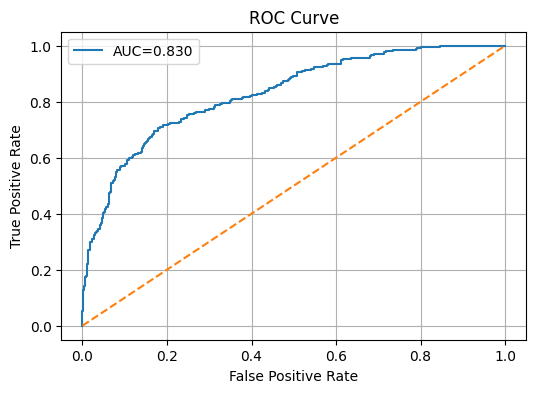

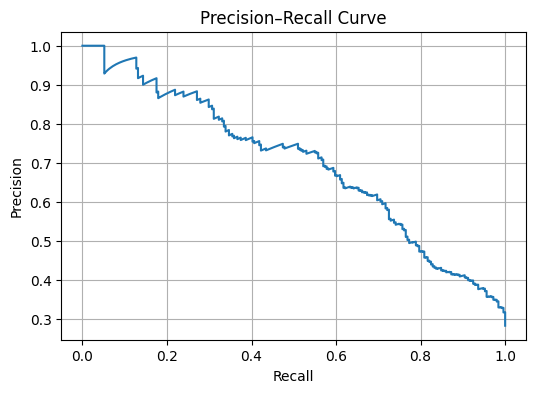

In [11]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()


In [12]:

artifacts_dir = "credit_model_artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

joblib.dump(model, os.path.join(artifacts_dir, "logreg_model.joblib"))
joblib.dump(scaler, os.path.join(artifacts_dir, "scaler.joblib"))
joblib.dump(X_train_cat.columns.tolist(), os.path.join(artifacts_dir, "cat_columns.joblib"))
joblib.dump(num_cols, os.path.join(artifacts_dir, "num_columns.joblib"))

print("Saved artifacts to folder:", artifacts_dir)


Saved artifacts to folder: credit_model_artifacts


In [13]:

model = joblib.load(os.path.join(artifacts_dir, "logreg_model.joblib"))
scaler = joblib.load(os.path.join(artifacts_dir, "scaler.joblib"))
cat_cols_saved = joblib.load(os.path.join(artifacts_dir, "cat_columns.joblib"))
num_cols_saved = joblib.load(os.path.join(artifacts_dir, "num_columns.joblib"))

new_df = X_test.head(5).copy()  

new_num = pd.DataFrame(scaler.transform(new_df[num_cols_saved]), columns=num_cols_saved, index=new_df.index) if num_cols_saved else pd.DataFrame(index=new_df.index)
new_cat = pd.get_dummies(new_df[cat_cols].astype(str), drop_first=True).reindex(columns=cat_cols_saved, fill_value=0)
new_pre = pd.concat([new_num, new_cat], axis=1)

proba = model.predict_proba(new_pre)[:,1]
pred = (proba >= 0.5).astype(int)

out = new_df.reset_index(drop=True).copy()
out['score'] = proba
out['pred'] = pred
display(out)


,Seniority,Time,Age,Expenses,Income,Assets,Debt,Amount,Price,debt_to_income,expenses_to_income,assets_to_debt,Home,Marital,Records,Job,score,pred
0,23,54,38,60,178,0,0,740,989,0.0,3.370786e-01,0.000000e+00,6,4,1,1,0.647761,1
1,19,60,49,135,150,3500,0,1100,1477,0.0,9.000000e-01,3.500000e+09,2,2,1,1,0.420269,0
2,1,36,19,35,118,0,0,1200,1426,0.0,2.966102e-01,0.000000e+00,5,1,1,2,0.789409,1
3,20,36,40,35,0,8500,400,750,1100,400000000.0,3.500000e+07,2.125000e+01,2,1,2,3,0.735263,1
4,0,48,54,35,67,5000,0,760,860,0.0,5.223881e-01,5.000000e+09,2,3,1,2,0.836740,1
